In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE

# 1. Data Preprocessing


## 1.1 Handle missing values (if any)

- no missing value

In [18]:
df = pd.read_csv('../data/heart.csv')

df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [19]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [20]:
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)


Duplicate rows: 723


In [21]:
df = df.drop_duplicates()
print("New shape:", df.shape)


New shape: (302, 14)


## 1.2 Encode categorical variables 

In [22]:
cat_cols = []
target_col = 'target'

for c in df.columns:
    if c == target_col:
        continue
    if df[c].dtype == "object":
        cat_cols.append(c)
    elif pd.api.types.is_integer_dtype(df[c]) and df[c].nunique() <= 15:
        cat_cols.append(c)

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(df_encoded.head())

   age  trestbps  chol  thalach  oldpeak  target  sex_1   cp_1   cp_2   cp_3  \
0   52       125   212      168      1.0       0   True  False  False  False   
1   53       140   203      155      3.1       0   True  False  False  False   
2   70       145   174      125      2.6       0   True  False  False  False   
3   61       148   203      161      0.0       0   True  False  False  False   
4   62       138   294      106      1.9       0  False  False  False  False   

   ...  exang_1  slope_1  slope_2   ca_1   ca_2   ca_3   ca_4  thal_1  thal_2  \
0  ...    False    False     True  False   True  False  False   False   False   
1  ...     True    False    False  False  False  False  False   False   False   
2  ...     True    False    False  False  False  False  False   False   False   
3  ...    False    False     True   True  False  False  False   False   False   
4  ...    False     True    False  False  False   True  False   False    True   

   thal_3  
0    True  
1    Tru

## 1.3 Feature scaling/normalization

## 1.4 Train/test split (80/20)

In [23]:
X = df.drop(columns='target')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 1.5 Explatory data analysis

In [24]:
counts = df['target'].value_counts()
print(counts)
print("Percent:")
print((counts / len(df) * 100).round(2))

target
1    164
0    138
Name: count, dtype: int64
Percent:
target
1    54.3
0    45.7
Name: count, dtype: float64


### 1.5.1 Bar Distribution for Target

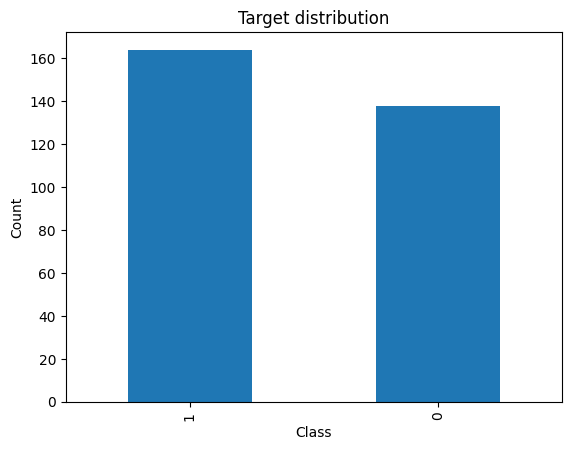

In [25]:
counts.plot(kind="bar")
plt.title("Target distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

### 1.5.2 Correlation of the dataframe without encoding categorical values

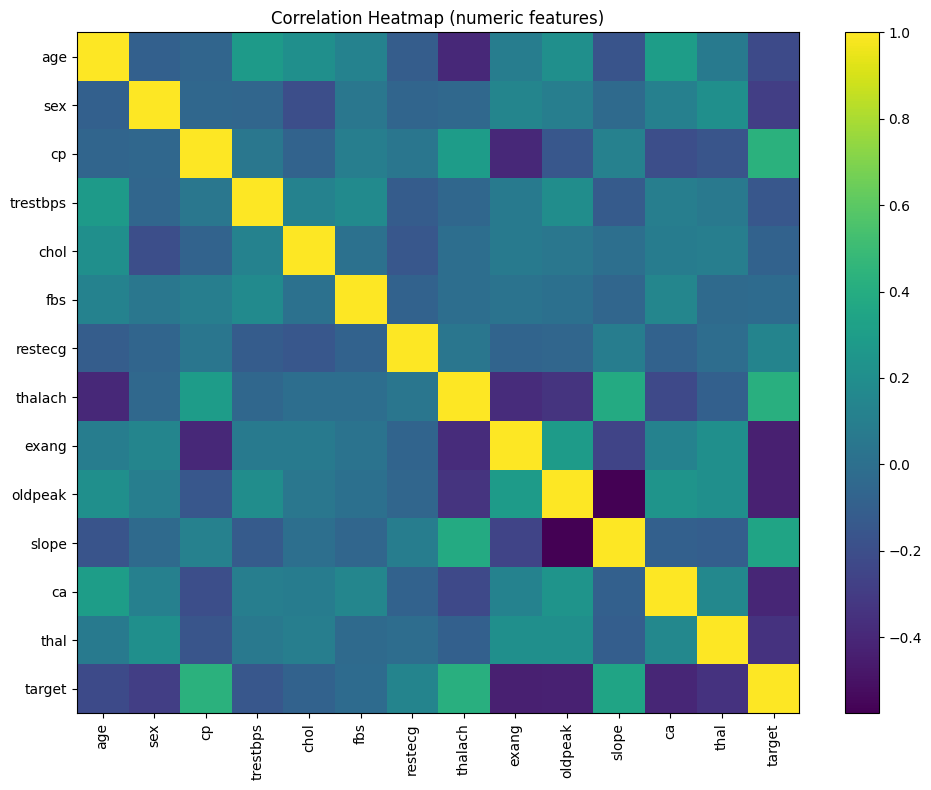

In [26]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
im = plt.imshow(corr, aspect="auto")
plt.colorbar(im)

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)

plt.title("Correlation Heatmap (numeric features)")
plt.tight_layout()
plt.show()

### 1.5.3 Correlation of the dataframe with encoding categorical values

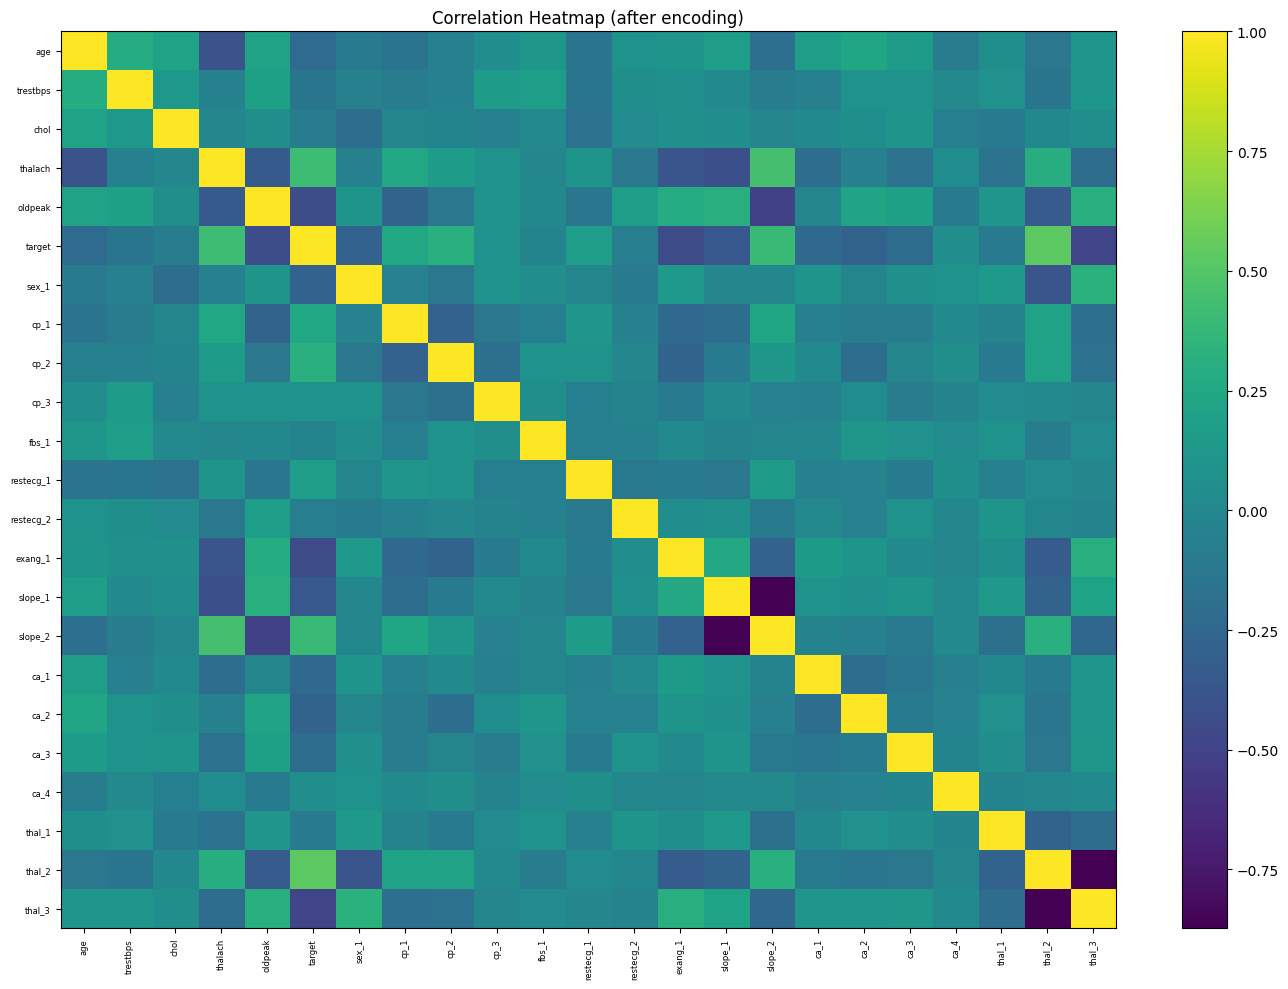

In [27]:
corr = df_encoded.corr()

plt.figure(figsize=(14, 10))
im = plt.imshow(corr, aspect="auto")
plt.colorbar(im)

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr.index)), corr.index, fontsize=6)

plt.title("Correlation Heatmap (after encoding)")
plt.tight_layout()
plt.show()

### 1.5.4 Distributions for numeric columns

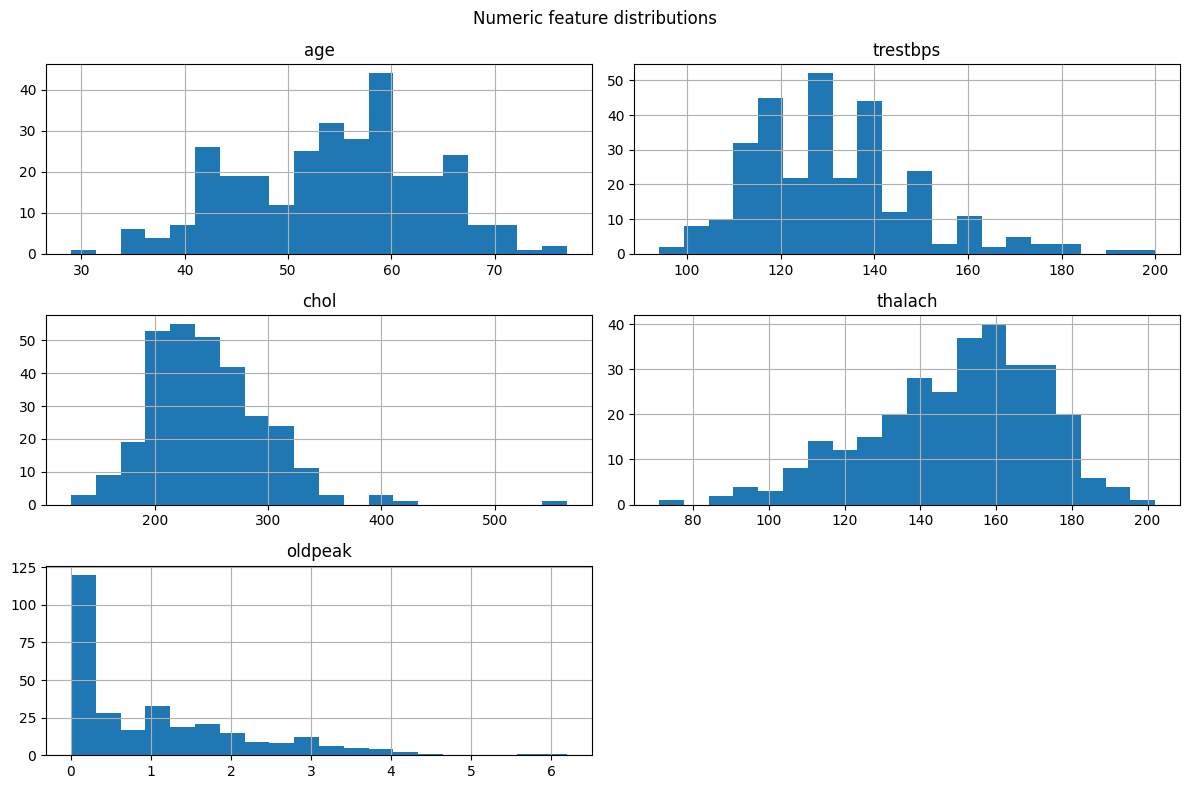

In [28]:
num_cols = [c for c in df.columns if c not in cat_cols + [target_col]]
df[num_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle("Numeric feature distributions")
plt.tight_layout()
plt.show()

### 1.5.5 Categorica Feature Distributions

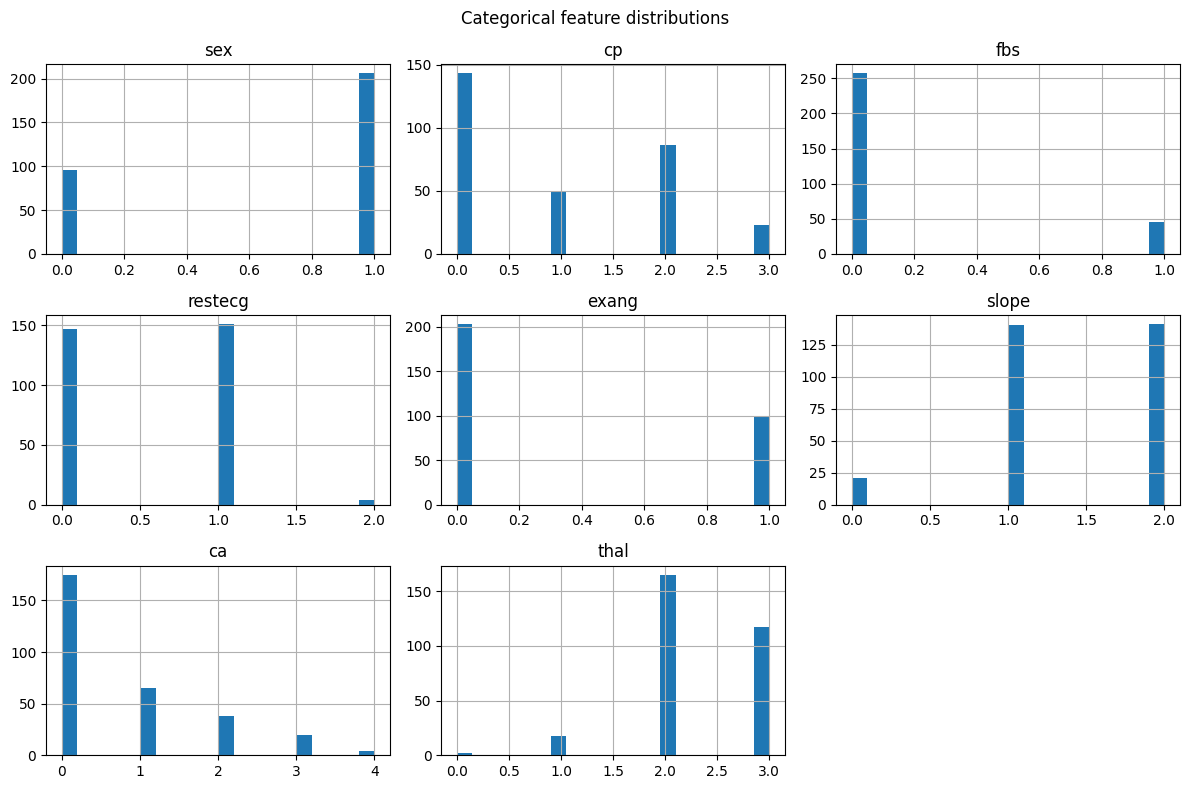

In [29]:
df[cat_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle("Categorical feature distributions")
plt.tight_layout()
plt.show()